In [1]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/t3home/gelliu/Unfolding_Substructure/CMSSW_10_6_5/python/jetObservables/Unfolding')
import CMS_lumi

Welcome to JupyROOT 6.14/09


In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1973000000,117200,7760,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626])
EventNumber=np.array([3520.33,6875125,4150588,9344512.12,6571952,8456672.59,6680029,831433,692968,834414,11166471])
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[2.01215926e+10 6.12020058e+02 6.71229040e+01 2.46697462e+00
 1.01555547e+00 1.36065230e-01 5.03324507e-02 3.62632943e-02
 5.82333499e-03 2.90515624e-04 5.22785149e-07]


In [3]:
fData=[]
path='/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_JetHTRun2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt-15to7000_TuneCUETP8M1_FlatP6_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_170to300_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_300to470_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_470to600_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_600to800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_800to1000_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1000to1400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1400to1800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1800to2400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_2400to3200_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_3200toInf_TuneCUETP8M1_13TeV_pythia8.root'
    ]

print len(fMC)

7
11


# Functions to refill histograms to new bins

In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Purity and stability calculation

In [5]:
def PurityStability(h0,bins):
    
    h=rt.TH2D("",";;",bins.shape[0]-1,(bins),bins.shape[0]-1,(bins))
    Fill2D(h0,h,bins,bins)
    hx=h.ProjectionX()
    hy=h.ProjectionY()
    N=hx.GetNbinsX()
    
    nreco_pergenbin=[]
    nreco_genanywhere=[]
    ngen_recoanywhere=[]
    for i in range(N):
        nreco_pergenbin.append(h.GetBinContent(i+1,i+1))
        nreco_genanywhere.append(hy.GetBinContent(i+1))
        ngen_recoanywhere.append(hx.GetBinContent(i+1))
    nreco_pergenbin=np.array(nreco_pergenbin)
    nreco_genanywhere=np.array(nreco_genanywhere)
    ngen_recoanywhere=np.array(ngen_recoanywhere)
    
    purity_arr=1.0*nreco_pergenbin/nreco_genanywhere
    stability_arr=1.0*nreco_pergenbin/ngen_recoanywhere
    
    purity=rt.TH1D("Purity",";;",bins.shape[0]-1,(bins))
    stability=rt.TH1D("Stability",";;",bins.shape[0]-1,(bins))
    
    for i in range(N):
        purity.SetBinContent(i+1,purity_arr[i])
        stability.SetBinContent(i+1,stability_arr[i])
    
    purity.SetLineWidth(2)
    purity.SetLineStyle(2)
    stability.SetLineWidth(2)
    stability.SetLineStyle(2)
    
    return purity,stability

# Do unfolding

In [6]:
def DoUnfolding(Response,Data_reco,MC_reco,MC_gen,HSname,MCname,gen_bins):
    
    tunfolderMC = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderMC.SetInput(MC_reco)
    MC_unfolded=tunfolderMC.DoUnfold(0.)
    MC_unfolded=tunfolderMC.GetOutput("MC_unfolded")
    
    tunfolderData = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderData.SetInput(Data_reco)
    Data_unfolded=tunfolderData.DoUnfold(0.)
    Data_unfolded=tunfolderData.GetOutput("Data_unfolded")
    
    MC_unfolded.SetMarkerStyle(2)
    MC_unfolded.SetMarkerColor(7)
    MC_unfolded.SetLineColor(7)
    MC_unfolded.SetLineWidth(1)
    
    Data_unfolded.SetMarkerStyle(22)
    Data_unfolded.SetMarkerColor(1)
    Data_unfolded.SetLineColor(1)
    Data_unfolded.SetLineWidth(2)
    
    MC_gen.SetMarkerStyle(5)
    MC_gen.SetMarkerColor(2)
    MC_gen.SetLineColor(2)
    
    ratio=rt.TH1D("Ratios "+HSname,"Ratios "+HSname+";"+HSname+";#frac{MC_unfolded}{MC_gen} ("+MCname+")",gen_bins.shape[0]-1,(gen_bins))
    ratio.Add(MC_unfolded)
    ratio.Divide(MC_gen)
    ratio.SetStats(0)
    ratio.SetMarkerStyle(5)
    ratio.SetMarkerColor(rt.kRed)
    ratio.SetLineColor(rt.kRed)
    ratio.GetYaxis().SetRangeUser(0.5,1.5)
    
    hs=rt.THStack(HSname,HSname)
    hs.Add(MC_unfolded,"E")
    hs.Add(MC_gen,"Hist")
    hs.Add(Data_unfolded,"E")
    
    leg=rt.TLegend(0.5, 0.5, 0.9, 0.8)
    #leg.SetTextSize(6)
    leg.AddEntry(Data_unfolded,"Data_unfolded",'p')
    leg.AddEntry(MC_unfolded,"MC_unfolded ("+MCname+")", 'p')
    leg.AddEntry(MC_gen,"MC_gen ("+MCname+")", 'f')
    leg.SetLineColor(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    return hs,ratio,leg

# $\tau_2^{(0.5)}$

In [8]:
reco='recoJet_tau_0p5_1_nom_dijetSel'
gen='genJet_tau_0p5_1_dijetSel'
response='respJet_tau_0p5_1_nom_dijetSel'

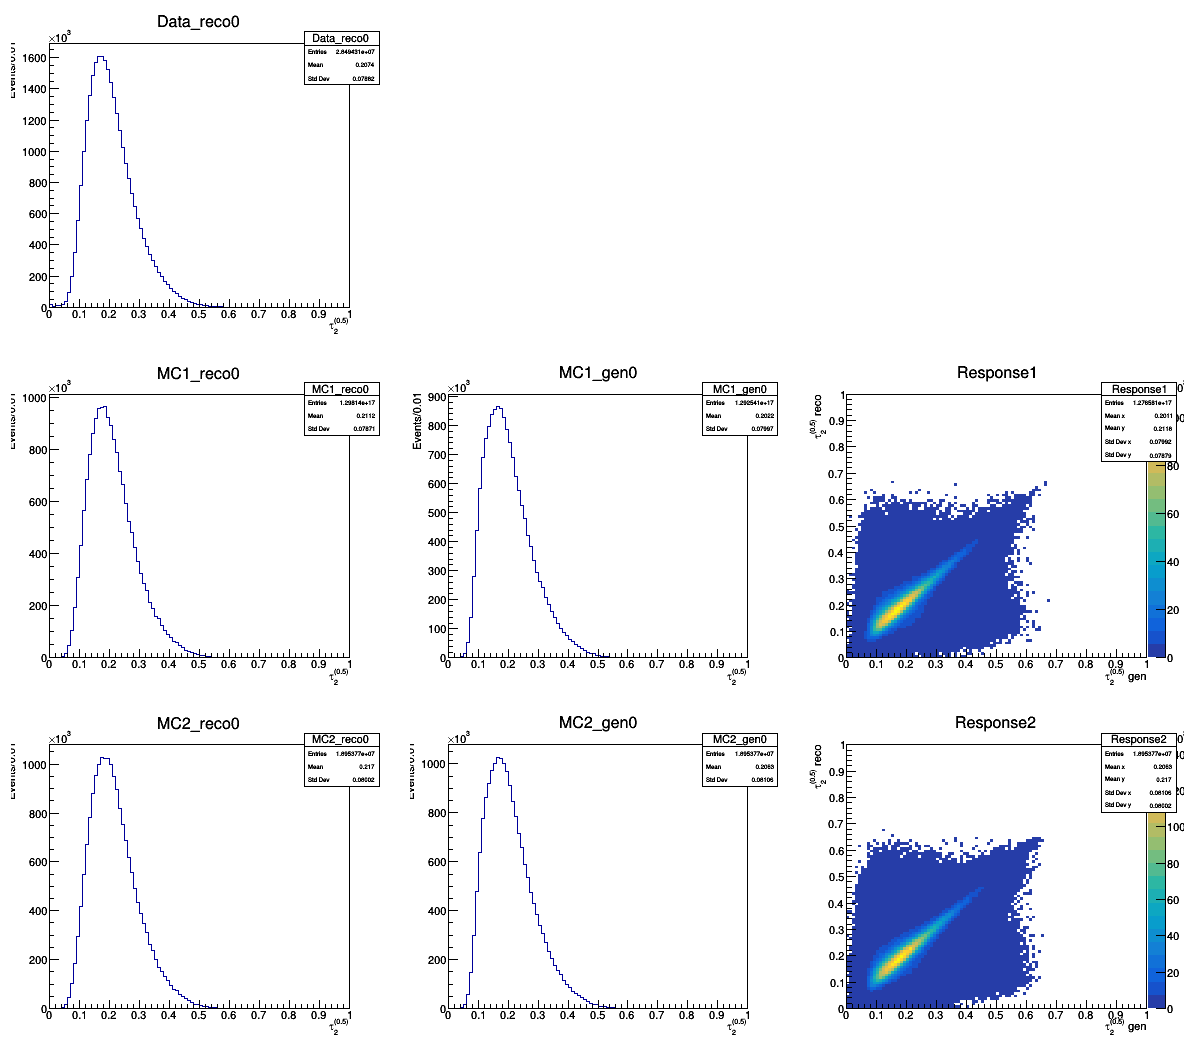

In [9]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{2}^{(0.5)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{2}^{(0.5)} gen;#tau_{2}^{(0.5)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{2}^{(0.5)} gen;#tau_{2}^{(0.5)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [11]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 878.53342728 1190.16548318
0.015 89.8341765527 363.479450683
0.025 236.195696955 746.893417461
0.035 801.842975467 1803.4090342
0.045 3601.53463052 5206.35163924
0.055 16740.2723146 18322.9911977
0.065 57847.536887 45191.2906529
0.075 149155.375183 103344.152915
0.085 298927.600517 184646.765549
0.095 477198.869207 294352.083935
0.105 639505.663576 415753.024633
0.115 776281.762402 548591.823638
0.125 863097.750975 672804.777498
0.135 921133.365512 783343.63501
0.145 971623.633724 878843.192485
0.155 1002132.49324 954523.574375
0.165 1026867.76393 997134.013451
0.175 1023531.44825 1027853.29092
0.185 1000661.48087 1024400.13698
0.195 969882.879529 1023605.39124
0.205 910987.623099 997208.315078
0.215 846357.912387 951187.238966
0.225 784846.720087 896340.820592
0.235 714440.273121 819525.451844
0.245 657329.136813 753108.966497
0.255 589912.281315 687402.245182
0.265 534985.52738 619401.710662
0.275 475466.660101 555627.900972
0.285 428482.662874 492358.704321
0.295 382502.90399 

# Different bins

In [30]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.48)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.68])))
reco_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.48)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.58,0.68])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=6,start=0.,stop=0.5)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.68])))
reco_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.5)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.59,0.68])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=8,start=0.,stop=0.56)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.68])))
reco_bins1=np.array([x for x in np.linspace(num=15,start=0.,stop=0.56)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.62,0.68])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=9,start=0.08,stop=0.56)])
gen_bins1=np.concatenate((np.array([0]),gen_bins1,np.array([0.68])))
reco_bins1=np.array([x for x in np.linspace(num=17,start=0.08,stop=0.56)])
reco_bins1=np.concatenate((np.array([0,0.04]),reco_bins1,np.array([0.62,0.68])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=15,start=0.,stop=0.56)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.68])))
reco_bins1=np.array([x for x in np.linspace(num=29,start=0.,stop=0.56)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.62,0.68])))
#print gen_bins1,gen_bins1.shape[0]-1
#print reco_bins1,reco_bins1.shape[0]-1

gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.12 0.24 0.36 0.48 0.68] 5
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.58 0.68] 10
[0.   0.1  0.2  0.3  0.4  0.5  0.68] 6
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.59 0.68] 12
[0.   0.08 0.16 0.24 0.32 0.4  0.48 0.56 0.68] 8
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.62 0.68] 16
[0.   0.08 0.14 0.2  0.26 0.32 0.38 0.44 0.5  0.56 0.68] 10
[0.   0.04 0.08 0.11 0.14 0.17 0.2  0.23 0.26 0.29 0.32 0.35 0.38 0.41
 0.44 0.47 0.5  0.53 0.56 0.62 0.68] 20
0.0,0.08,0.14,0.2,0.26,0.32,0.38000000000000006,0.44000000000000006,0.5,0.56,0.68
0.0,0.04,0.08,0.11,0.14,0.17,0.2,0.23000000000000004,0.26,0.29000000000000004,0.32,0.35000000000000003,0.38000000000000006,0.41000000000000003,0.44000000000000006,0.47000000000000003,0.5,0.53,0.56,0.62,0.68


In [19]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{2}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{2}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{2}^{(0.5)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{2}^{(0.5)} gen;#tau_{2}^{(0.5)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{2}^{(0.5)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{2}^{(0.5)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{2}^{(0.5)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.12 0.24 0.36 0.48 0.68]
for binning 2
[0.   0.1  0.2  0.3  0.4  0.5  0.68]
for binning 3
[0.   0.08 0.16 0.24 0.32 0.4  0.48 0.56 0.68]
for binning 4
[0.   0.08 0.14 0.2  0.26 0.32 0.38 0.44 0.5  0.56 0.68]
for binning 5
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.68]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 10 input bins and 5 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{2}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #6 (xaxis:#tau_{2}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 d

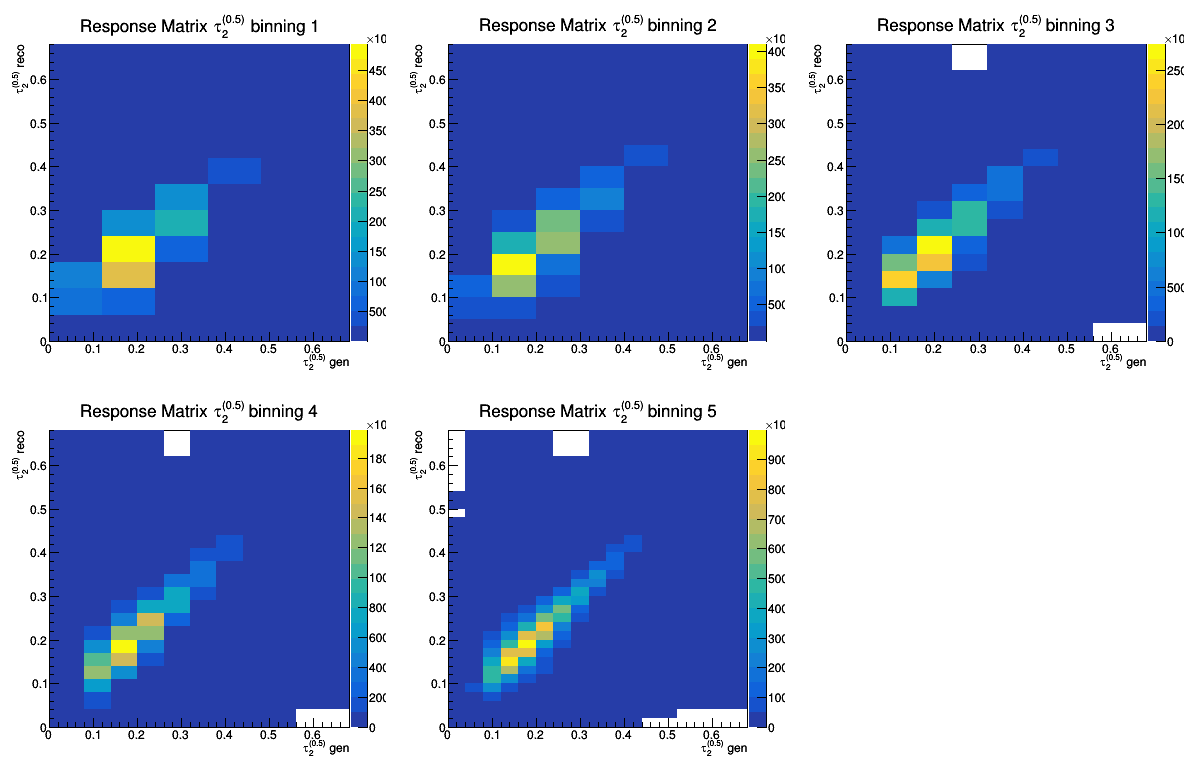

In [20]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


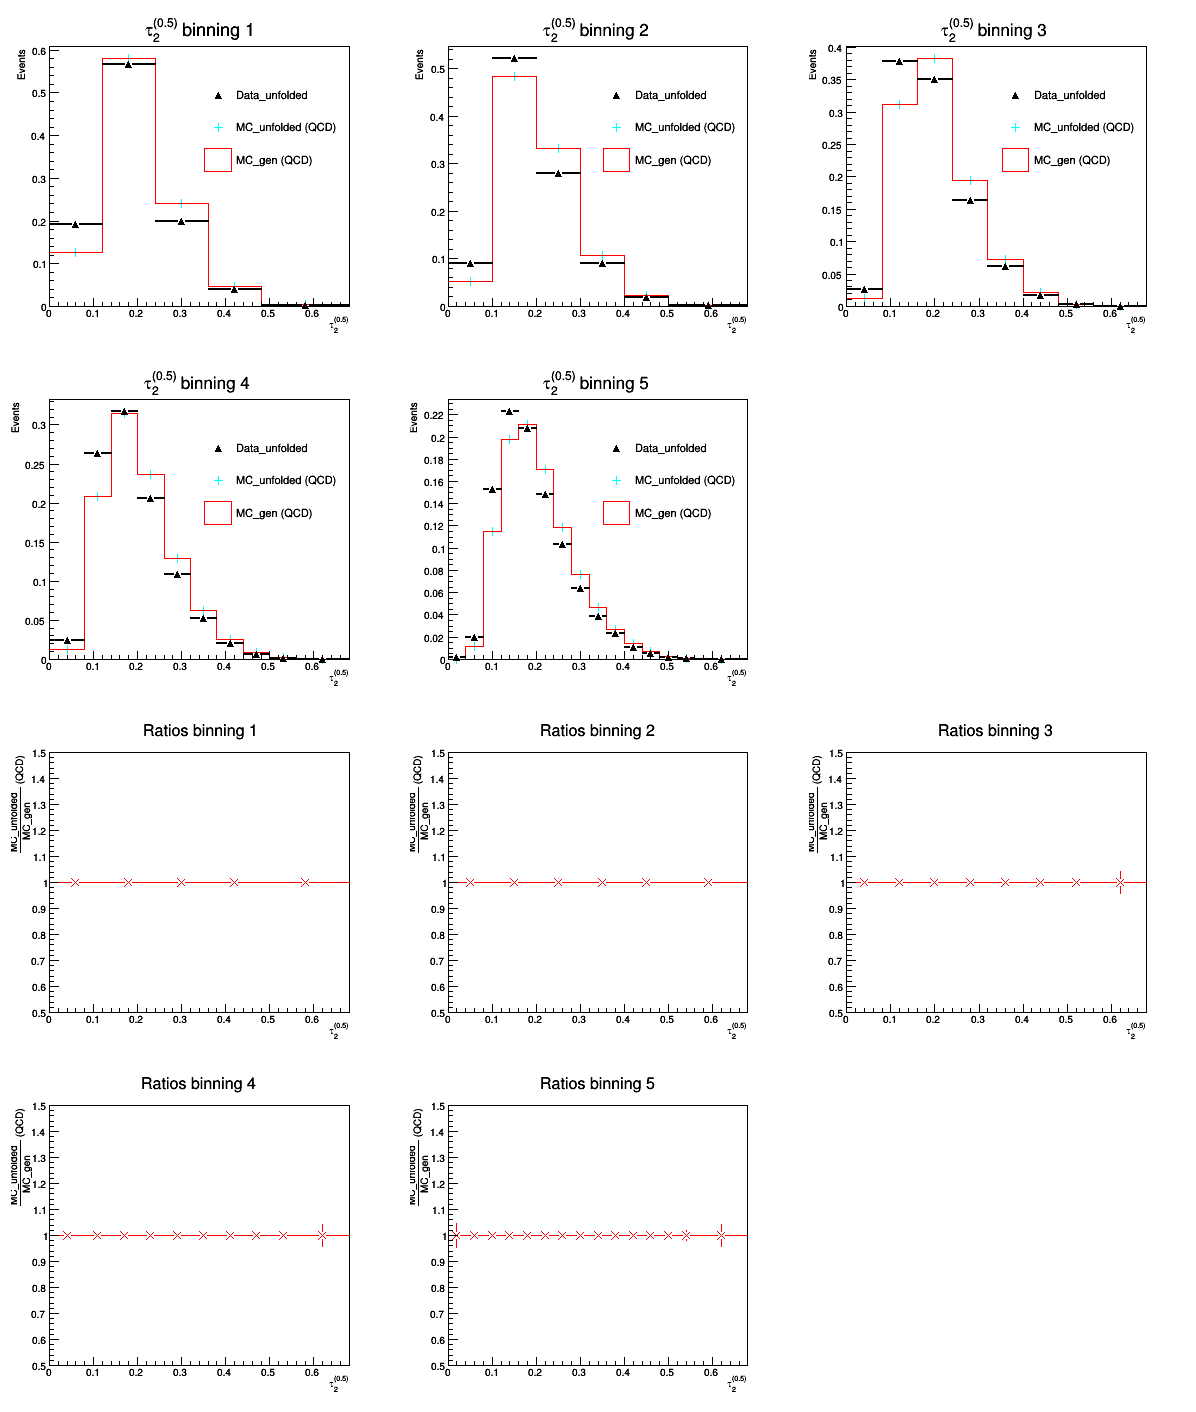

In [21]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{2}^{(0.5)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,6+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

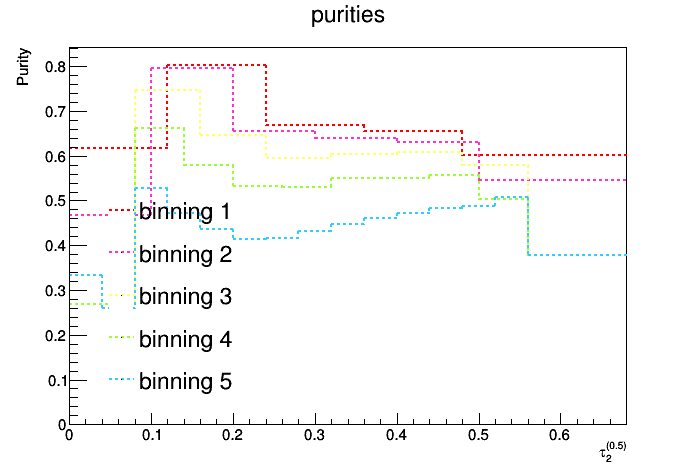

In [22]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{2}^{(0.5)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

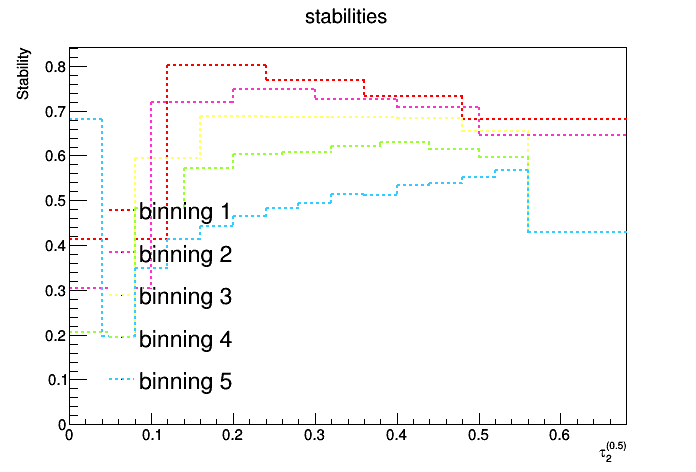

In [24]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{2}^{(0.5)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_tau_0p5_1_dijetSel.png has been created
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_tau_0p5_1_dijetSel.png has been created


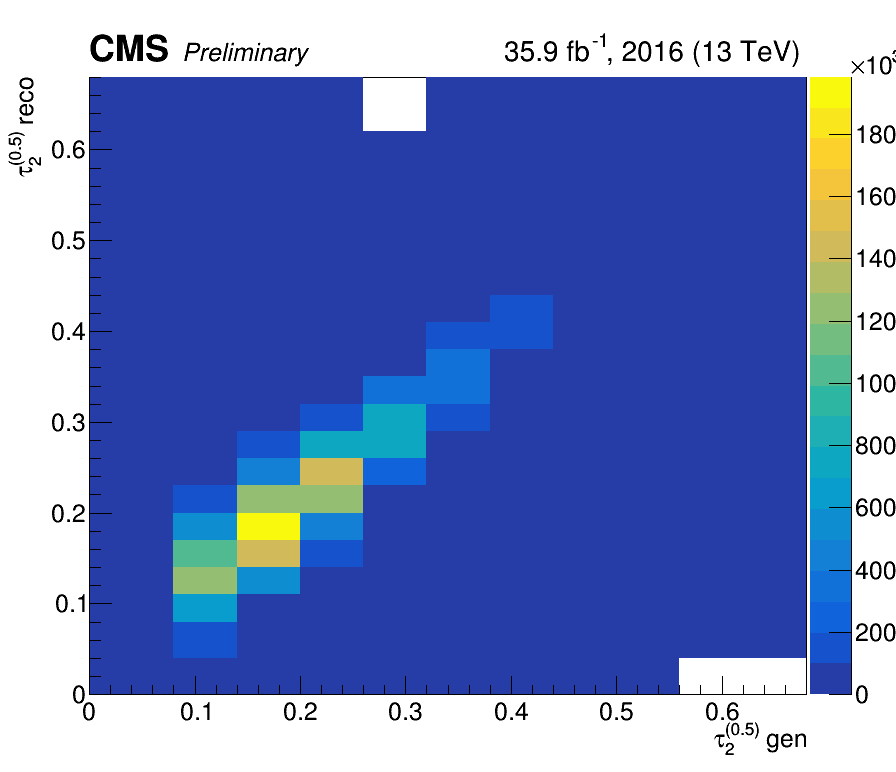

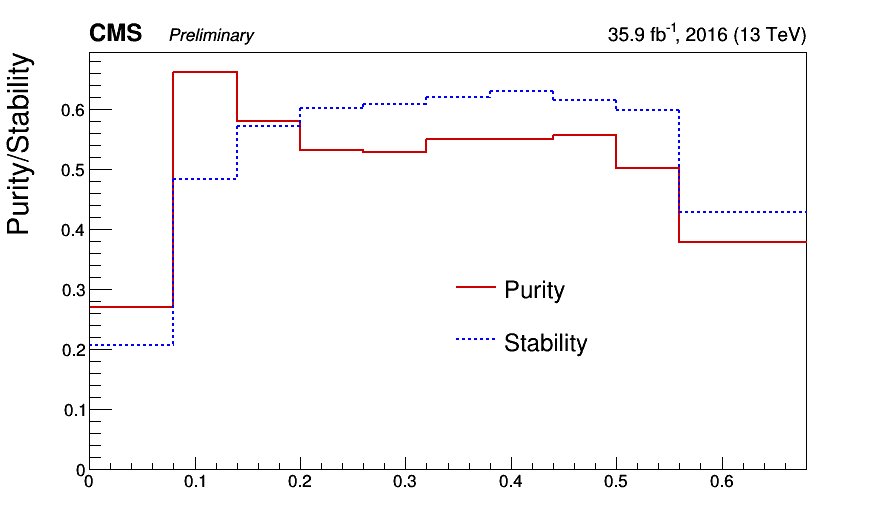

In [25]:
i=3
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c1=rt.TCanvas("","",0,0,900,800)
responses[i].SetTitle("")
responses[i].Draw("Colz")
CMS_lumi.CMS_lumi(c1,4,0)
c1.Draw()
c1.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_'+gen.split("t_")[1]+'.png')

CMS_lumi.relPosX=0.11
c2=rt.TCanvas("1","1",0,0,900,550)
ps=rt.THStack("","")
hist_purities[i].SetLineStyle(1)
hist_purities[i].SetLineColor(rt.kRed+1)
hist_stabilities[i].SetLineStyle(2)
hist_stabilities[i].SetLineColor(rt.kBlue)
ps.Add(hist_purities[i],"hist")
ps.Add(hist_stabilities[i],"hist")
ps.Draw("nostack")
#ps.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
ps.GetYaxis().SetTitle("Purity/Stability")
ps.GetYaxis().SetTitleSize(0.06)
ps.GetYaxis().SetTitleOffset(0.8)
leg=rt.TLegend(0.5,0.3,0.75,0.5)
leg.AddEntry(hist_purities[i],"Purity","l")
leg.AddEntry(hist_stabilities[i],"Stability","l")
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
CMS_lumi.CMS_lumi(c2,4,0)
c2.Draw()
c2.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_'+gen.split("t_")[1]+'.png')

# $\tau_{2}^{(1)}$

In [37]:
reco='recoJet_tau_1_1_nom_dijetSel'
gen='genJet_tau_1_1_dijetSel'
response='respJet_tau_1_1_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


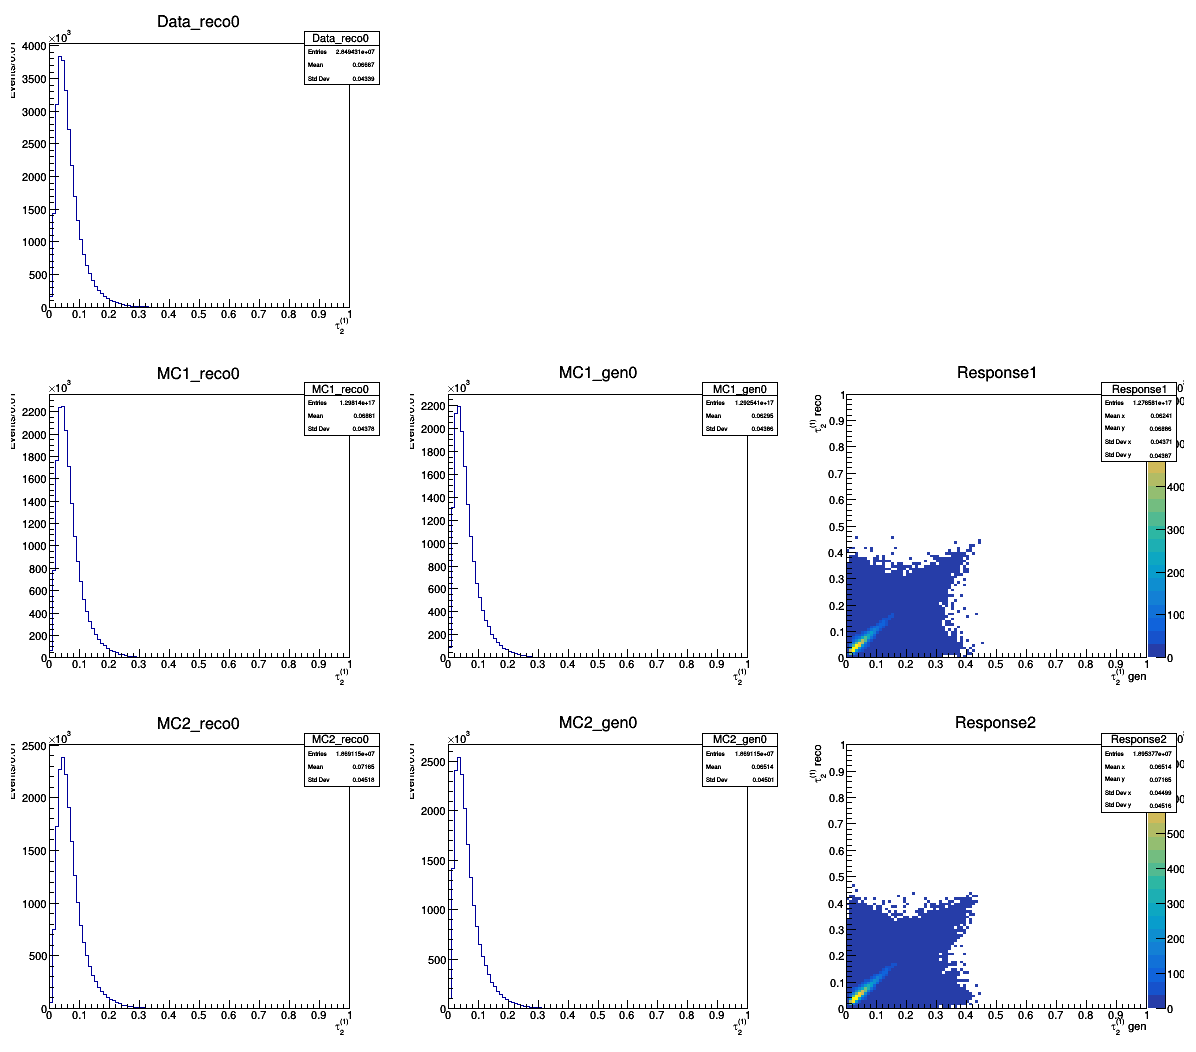

In [38]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{2}^{(1)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{2}^{(1)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{2}^{(1)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{2}^{(1)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{2}^{(1)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{2}^{(1)} gen;#tau_{2}^{(1)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{2}^{(1)} gen;#tau_{2}^{(1)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [39]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 102957.309903 61320.8937584
0.015 1415127.72051 747380.010793
0.025 2413868.7616 1725094.51977
0.035 2542674.62322 2267112.96263
0.045 2365374.88855 2384041.3931
0.055 2029726.66085 2220684.39778
0.065 1658720.86315 1904912.46337
0.075 1323027.61915 1583112.54335
0.085 1046814.74292 1259645.2195
0.095 834645.166311 1006530.19475
0.105 647217.812544 792094.906703
0.115 531007.037043 622812.673734
0.125 430910.475239 501971.846712
0.135 346577.253368 402567.407054
0.145 264076.406206 317575.616925
0.155 218538.235043 255429.777821
0.165 175471.178639 203364.268727
0.175 143804.551937 158605.308534
0.185 111337.877109 130501.692919
0.195 92244.5316916 102357.408916
0.205 73705.4212954 81920.3845674
0.215 62654.9698709 72260.969186
0.225 49853.373549 56646.2186531
0.235 36726.5964248 45224.0509933
0.245 28667.5173687 30446.8096058
0.255 21922.0860411 26769.5605087
0.265 18125.9625452 19514.9618945
0.275 13481.3714126 15227.7302421
0.285 11110.2695472 10748.7618934
0.295 7603.04475888

In [40]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.24)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.47])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.24)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.36,0.47])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=6,start=0.,stop=0.3)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.47])))
reco_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.30)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.38,0.47])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=8,start=0.,stop=0.28)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.47])))
reco_bins1=np.array([x for x in np.linspace(num=15,start=0.,stop=0.28)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.37,0.47])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=15,start=0.,stop=0.28)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.47])))
reco_bins1=np.array([x for x in np.linspace(num=29,start=0.,stop=0.28)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.37,0.47])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.08 0.16 0.24 0.47] 4
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.36 0.47] 8
[0.   0.06 0.12 0.18 0.24 0.3  0.47] 6
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.38 0.47] 12
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.47] 8
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.37 0.47] 16
0.0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.47
0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.37,0.47
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.47] 15
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.37 0.47] 30


In [41]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{2}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{2}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{2}^{(1)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{2}^{(1)} gen;#tau_{2}^{(1)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{2}^{(1)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{2}^{(1)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{2}^{(1)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.08 0.16 0.24 0.47]
for binning 2
[0.   0.06 0.12 0.18 0.24 0.3  0.47]
for binning 3
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.47]
for binning 4
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.47]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 8 input bins and 4 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{2}^{(1)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (xaxis:#tau_{2}^{(1)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densit

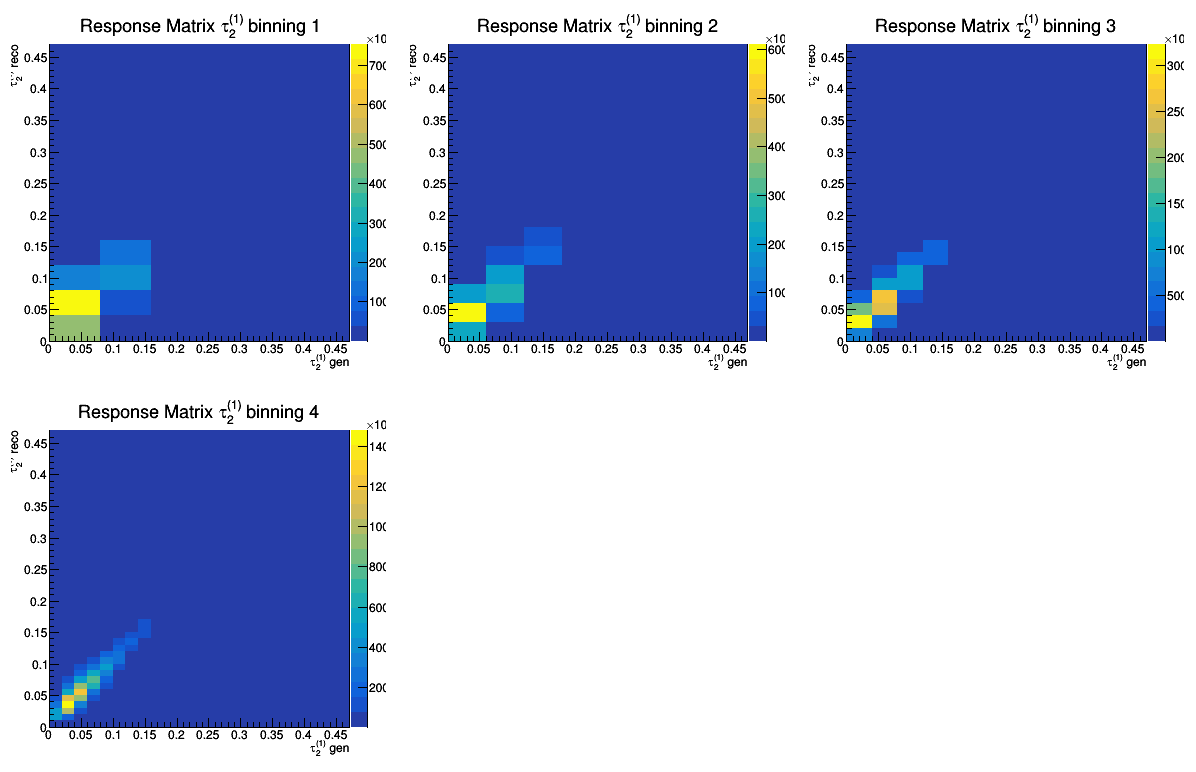

In [42]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


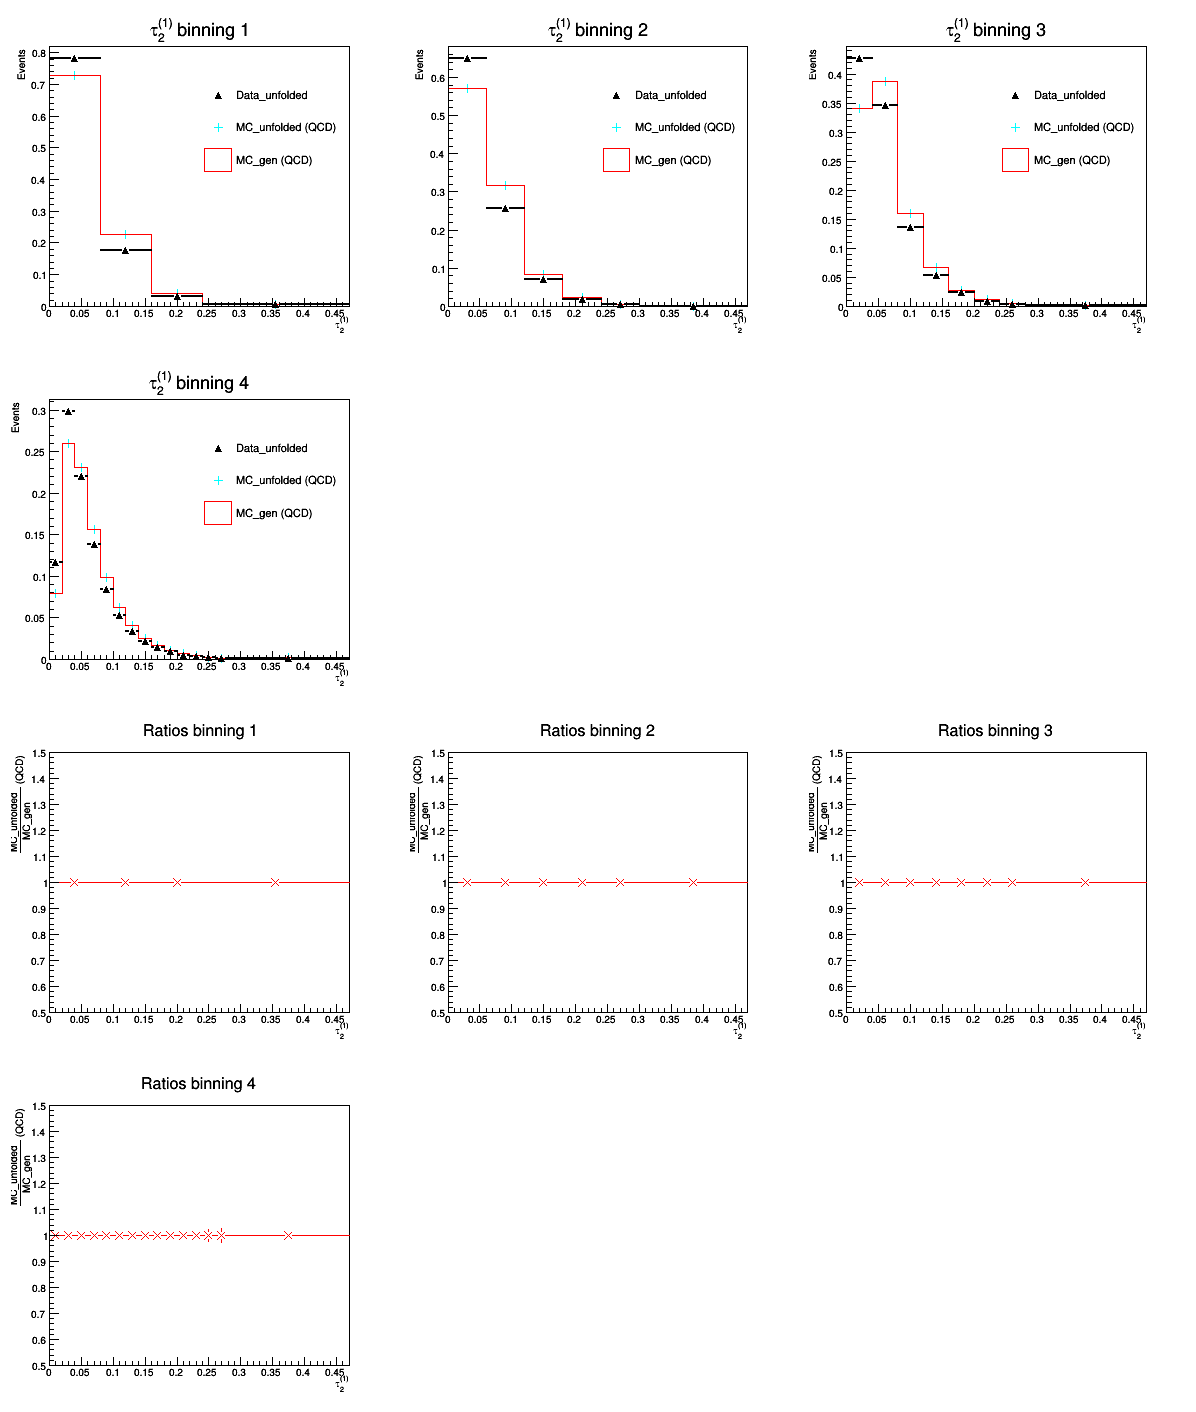

In [43]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{2}^{(1)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,len(gen_bins)+6):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

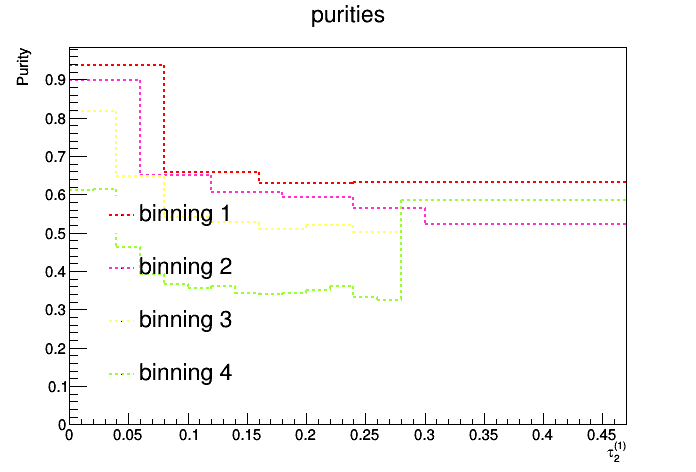

In [44]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{2}^{(1)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

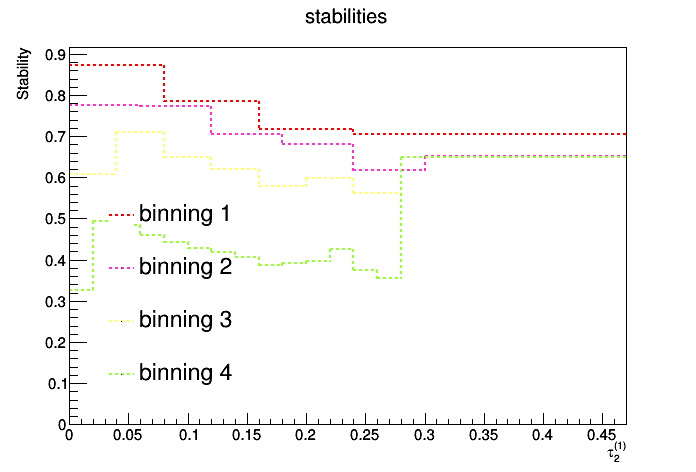

In [45]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{2}^{(1)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_tau_1_1_dijetSel.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 1
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_tau_1_1_dijetSel.png has been created


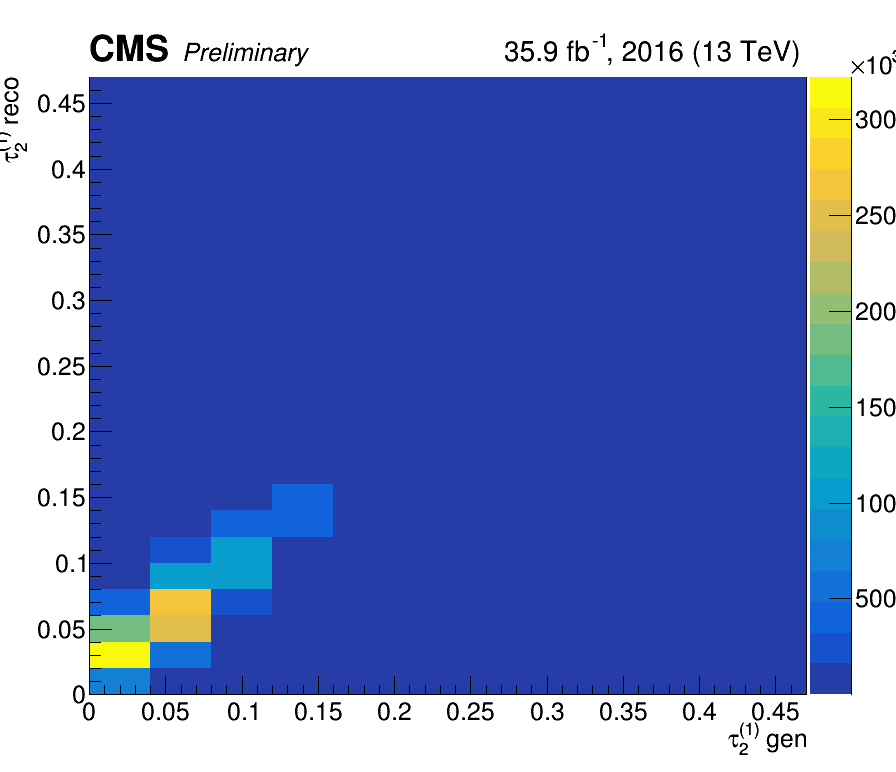

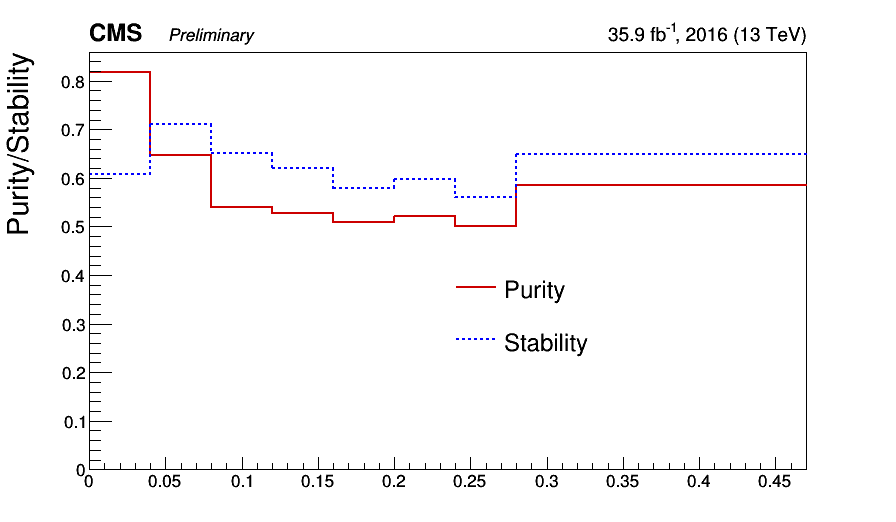

In [46]:
i=2
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c1=rt.TCanvas("","",0,0,900,800)
responses[i].SetTitle("")
responses[i].Draw("Colz")
CMS_lumi.CMS_lumi(c1,4,0)
c1.Draw()
c1.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_'+gen.split("t_")[1]+'.png')

CMS_lumi.relPosX=0.11
c2=rt.TCanvas("1","1",0,0,900,550)
ps=rt.THStack("","")
hist_purities[i].SetLineStyle(1)
hist_purities[i].SetLineColor(rt.kRed+1)
hist_stabilities[i].SetLineStyle(2)
hist_stabilities[i].SetLineColor(rt.kBlue)
ps.Add(hist_purities[i],"hist")
ps.Add(hist_stabilities[i],"hist")
ps.Draw("nostack")
#ps.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
ps.GetYaxis().SetTitle("Purity/Stability")
ps.GetYaxis().SetTitleSize(0.06)
ps.GetYaxis().SetTitleOffset(0.8)
leg=rt.TLegend(0.5,0.3,0.75,0.5)
leg.AddEntry(hist_purities[i],"Purity","l")
leg.AddEntry(hist_stabilities[i],"Stability","l")
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
CMS_lumi.CMS_lumi(c2,4,0)
c2.Draw()
c2.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_'+gen.split("t_")[1]+'.png')

# $\tau_2^{(2)}$

In [47]:
reco='recoJet_tau_2_1_nom_dijetSel'
gen='genJet_tau_2_1_dijetSel'
response='respJet_tau_2_1_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


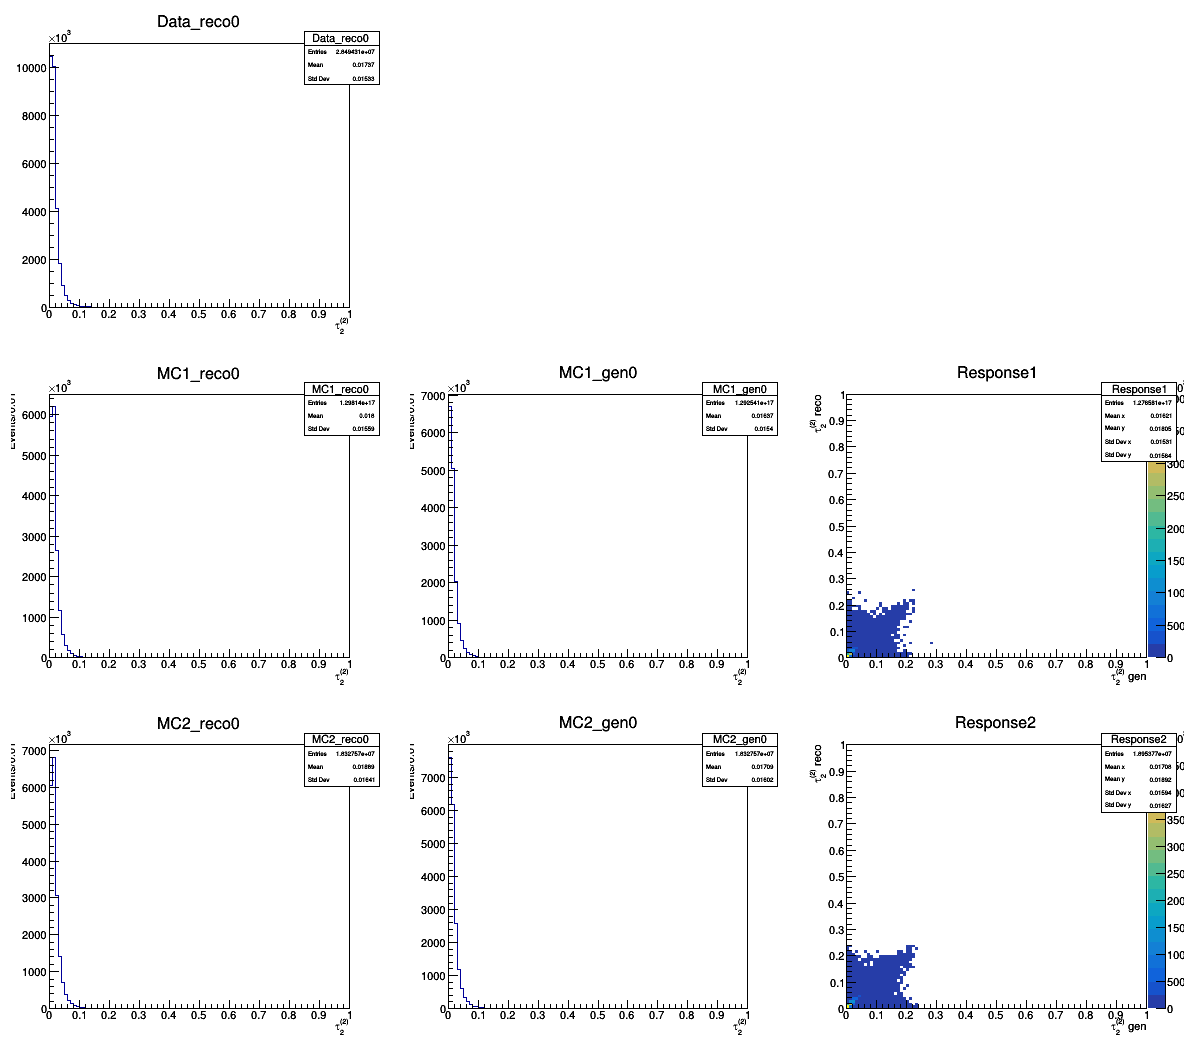

In [48]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{2}^{(2)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{2}^{(2)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{2}^{(2)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{2}^{(2)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{2}^{(2)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{2}^{(2)} gen;#tau_{2}^{(2)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{2}^{(2)} gen;#tau_{2}^{(2)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [49]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 7619025.42969 6060079.71374
0.015 6177186.95043 6814415.63526
0.025 2591222.22463 3080017.33421
0.035 1182926.82997 1398377.2852
0.045 606700.224917 713869.868743
0.055 339624.381884 387293.100653
0.065 198594.536393 228323.646536
0.075 125075.867454 137142.101528
0.085 74948.1733953 80641.8265872
0.095 47599.4387769 53681.7738425
0.105 27728.8089496 29741.3912691
0.115 17604.6929182 21053.5900649
0.125 10666.2381424 12784.0038065
0.135 7263.49518524 7216.05791887
0.145 5230.74645591 5114.82222173
0.155 2863.68572181 3542.37976656
0.165 1170.15484293 1538.70482651
0.175 552.124592198 787.0529287
0.185 466.422042873 499.362175454
0.195 184.23693391 243.460922511
0.205 107.569297998 83.3812137324
0.215 18.7259609218 236.493569411
0.225 3.06227547435 75.7339562333
0.235 3.73551137548 9.03544971457
0.245 0.0 0.0
0.255 0.0 0.0
0.265 0.0 0.0
0.275 0.0 0.0
0.285 0.0 0.0
0.295 0.0 0.0
0.305 0.0 0.0
0.315 0.0 0.0
0.325 0.0 0.0
0.335 0.0 0.0
0.345 0.0 0.0
0.355 0.0 0.0
0.365 0.0 0.0
0.375 

In [58]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.12)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.24])))
reco_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.12)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.18,0.24])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.12)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.24])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.12)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.18,0.24])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.08)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.12,0.24])))
reco_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.08)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.10,0.12,0.18,0.24])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.06 0.12 0.24] 3
[0.   0.03 0.06 0.09 0.12 0.18 0.24] 6
[0.   0.04 0.08 0.12 0.24] 4
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.18 0.24] 8
[0.   0.02 0.04 0.06 0.08 0.12 0.24] 6
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.1  0.12 0.18 0.24] 12
0.0,0.02,0.04,0.06,0.08,0.12,0.24
0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.1,0.12,0.18,0.24


In [59]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{2}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{2}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{2}^{(2)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{2}^{(2)} gen;#tau_{2}^{(2)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{2}^{(2)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{2}^{(2)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{2}^{(2)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.06 0.12 0.24]
for binning 2
[0.   0.04 0.08 0.12 0.24]
for binning 3
[0.   0.02 0.04 0.06 0.08 0.12 0.24]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 6 input bins and 3 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{2}^{(2)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #4 (xaxis:#tau_{2}^{(2)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densit

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


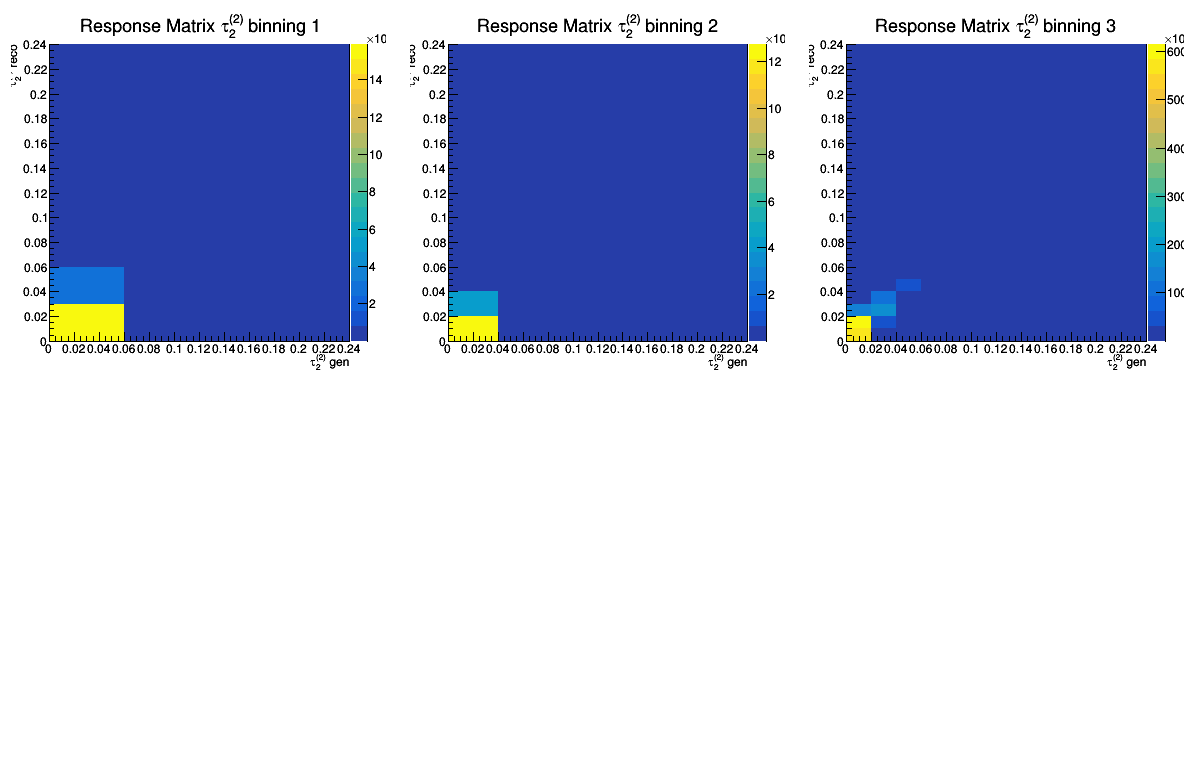

In [60]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


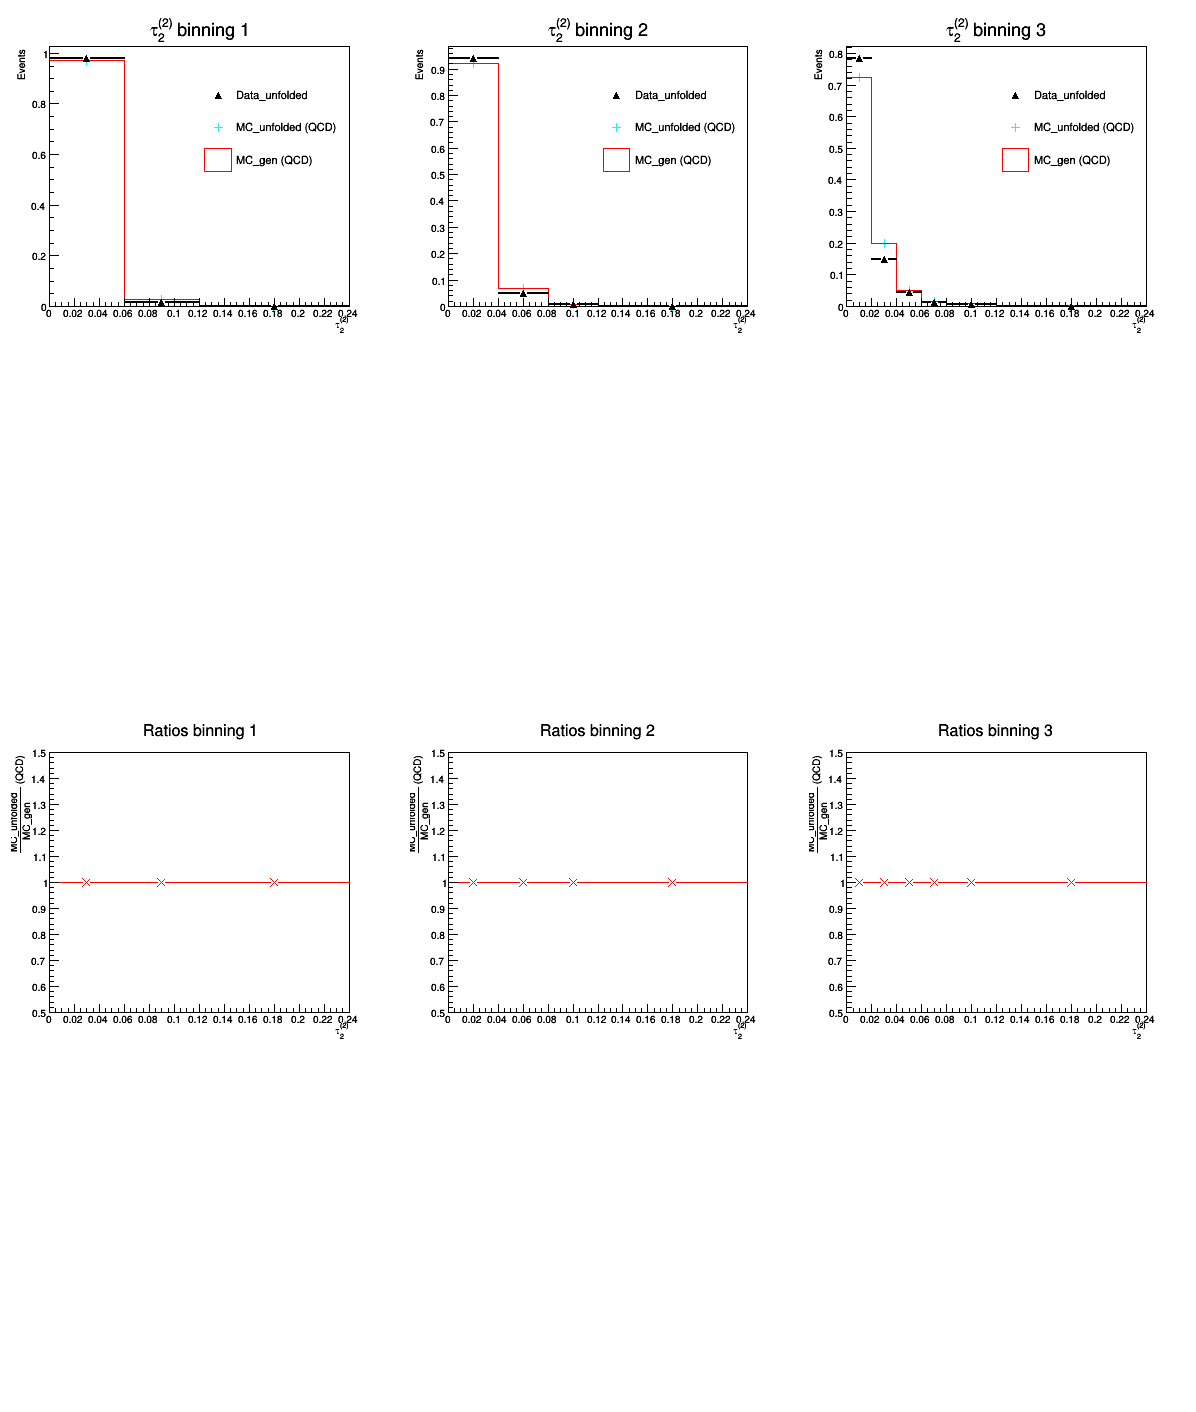

In [61]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{2}^{(2)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,6+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

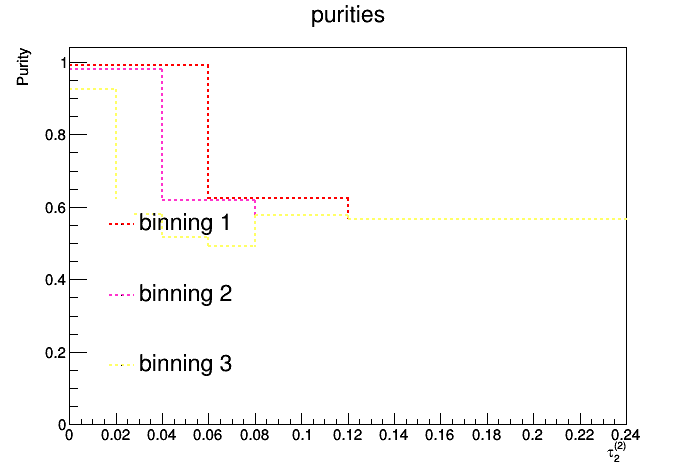

In [62]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{2}^{(2)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

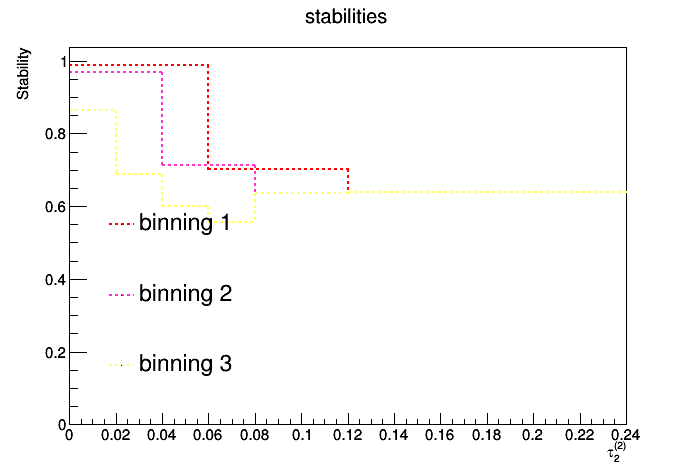

In [63]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{2}^{(2)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_tau_2_1_dijetSel.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 1
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_tau_2_1_dijetSel.png has been created


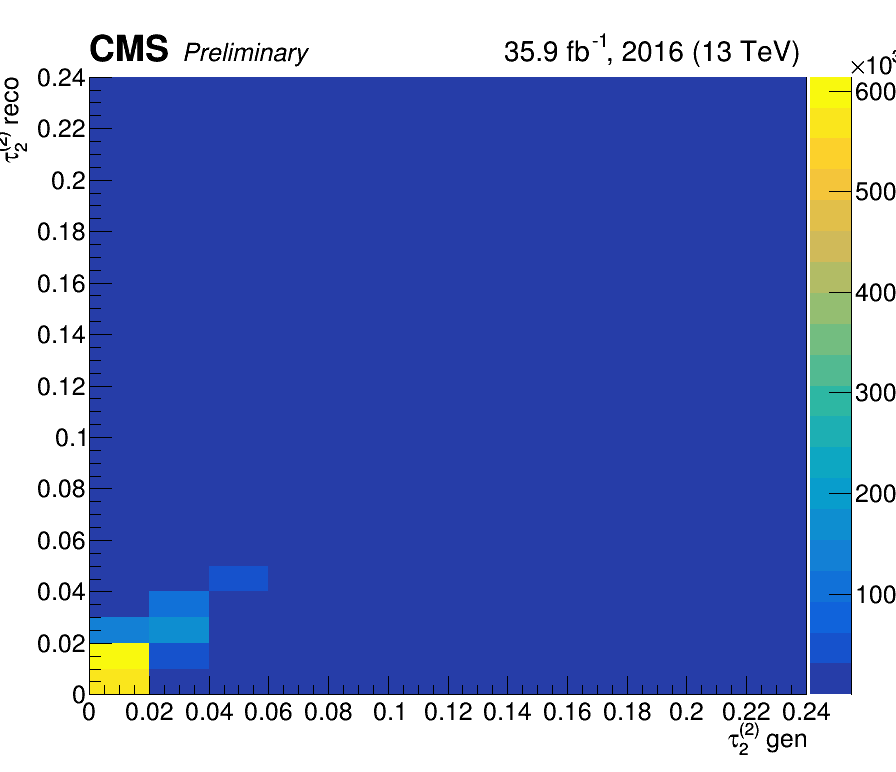

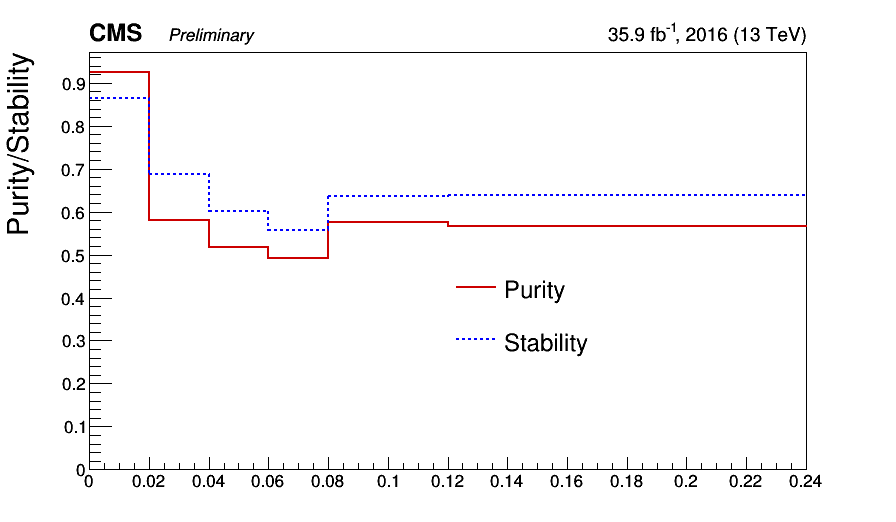

In [64]:
i=2
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c1=rt.TCanvas("","",0,0,900,800)
responses[i].SetTitle("")
responses[i].Draw("Colz")
CMS_lumi.CMS_lumi(c1,4,0)
c1.Draw()
c1.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_'+gen.split("t_")[1]+'.png')

CMS_lumi.relPosX=0.11
c2=rt.TCanvas("1","1",0,0,900,550)
ps=rt.THStack("","")
hist_purities[i].SetLineStyle(1)
hist_purities[i].SetLineColor(rt.kRed+1)
hist_stabilities[i].SetLineStyle(2)
hist_stabilities[i].SetLineColor(rt.kBlue)
ps.Add(hist_purities[i],"hist")
ps.Add(hist_stabilities[i],"hist")
ps.Draw("nostack")
#ps.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
ps.GetYaxis().SetTitle("Purity/Stability")
ps.GetYaxis().SetTitleSize(0.06)
ps.GetYaxis().SetTitleOffset(0.8)
leg=rt.TLegend(0.5,0.3,0.75,0.5)
leg.AddEntry(hist_purities[i],"Purity","l")
leg.AddEntry(hist_stabilities[i],"Stability","l")
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
CMS_lumi.CMS_lumi(c2,4,0)
c2.Draw()
c2.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_'+gen.split("t_")[1]+'.png')